# **Curso**: Deep Learning

[<img align="right" width="400" height="100" src="https://assets.website-files.com/5f909dbbf6ef7c3b428e2522/60f4592942eda3c0ffb35bfd_Logo_QLAB.svg">](https://qlab.pucp.edu.pe/)


[Pedro Achanccaray](mailto:p.diaz@tu-braunschweig.de), y [Smith Arauco](mailto:saraucoc@uni.pe).

[Pontificia Universidad Católica del Perú](https://www.pucp.edu.pe/)  
[Laboratorio de Inteligencia Artificial y Métodos Computacionales en Ciencias Sociales](https://qlab.pucp.edu.pe/formacion-continua)

# **Lab 3: Transfer Learning y Fine Tuning**

En esta sesión vamos a ver los siguientes temas:
- Transfer learning y Fine tuning, usando modelos pre-entrenados para otras aplicaciones

En esta ocasión vamos a usar el dataset [UC Merced](http://weegee.vision.ucmerced.edu/datasets/landuse.html) (~320 MB), el cual contiene 21 clases, 100 imagenes por clase, tamaño: $256×256$.

<center>

|Class| Description ||| Class | Description |
|:---:|:-----------:|||:-----:|:-----------:|
|  0  | agricultural|||  10   |    harbor   |
|  1  |  airplane   |||  11   |intersection |
|  2  |baseballdiamond|||12   |mediumresidential|
|  3  |   beach     |||  13   |mobilehomepark|
|  4  |  buildings  |||  14   |  overpass   |
|  5  |  chaparral  |||  15   | parkinglot  |
|  6  |denseresidential|||16  |    river    |
|  7  |    forest   |||  17   |   runway    |
|  8  |  freeway    |||  18   |sparseresidential|
|  9  | golfcourse  |||  19   | storagetanks|
|     |             |||  20   | tenniscourt |

</center>

## **Montar Google Drive a Google Colab**

**Ejecutar las siguiente lineas de código solo si deseas guardar el módelo entrenado y el conjunto de datos.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/DL_QLAB/Deep_Learning/Semana_3

/content/drive/MyDrive/DL_QLAB/Deep_Learning/Semana_3


## **Cargando el conjunto de datos**

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from os.path import join,basename
from glob import glob
from natsort import natsorted
import pandas as pd
import tifffile
import datetime, os
import cv2

# External files with functions to load the dataset,
# create a CNN model, and a data generator.
from importlib import reload
import datasets
import data_generator
# Useful to reload modified external files without need
# of restarting the kernel. Just run again this cell.
reload(datasets)
reload(data_generator)

from datasets import *
from data_generator import *

**Variables**

In [4]:
PROJECT_DIR = "." # os.getcwd()
SEED = 42
BATCH_SIZE = 32
TARGET_SIZE = 256
EPOCHS = 200

**Descargando el conjunto de datos**

En el archivo `datasets.py` tenemos funciones auxiliares para descargar, leer, y procesar el conjunto de datos.

**Ejecutar al siguiente linea solo la primera vez que se desee descargar el conjunto de datos**

In [5]:
download_ucmerced(PROJECT_DIR)

**Leyendo el conjunto de datos**

Para un mejor manejo del conjunto de datos, vamos a crear un Dataframe con información sobre:
- `path_image`: path de la imagen
- `class_str`: nombre de la clase de la imagen, en formato `string`
- `class_int`: clase de la imagen en formato `int`

In [6]:
path_data = join(PROJECT_DIR, "UCMerced_LandUse", "Images")

df, n_classes = read_ucmerced(path_data=path_data, SEED=SEED)
classes = np.unique(df["class_str"].values)

df

,path_image,class_str,class_int
0,./UCMerced_LandUse/Images/harbor/harbor34.tif,harbor,10
1,./UCMerced_LandUse/Images/intersection/interse...,intersection,11
2,./UCMerced_LandUse/Images/agricultural/agricul...,agricultural,0
3,./UCMerced_LandUse/Images/mobilehomepark/mobil...,mobilehomepark,13
4,./UCMerced_LandUse/Images/denseresidential/den...,denseresidential,6
...,...,...,...
2095,./UCMerced_LandUse/Images/river/river38.tif,river,16
2096,./UCMerced_LandUse/Images/harbor/harbor95.tif,harbor,10
2097,./UCMerced_LandUse/Images/intersection/interse...,intersection,11
2098,./UCMerced_LandUse/Images/mediumresidential/me...,mediumresidential,12


### **Train, validation y test**

Vamos a usar las siguientes proporciones para cada conjunto:
- `train`: 60%
- `validation`: 20%
- `test`: 20%

La definición de la función `train_val_test_split` está en el archivo `datasets.py`

In [7]:
splits = train_val_test_split(df,
                              val_size=0.2,
                              test_size=0.2,
                              SEED=SEED)

x_train = splits["x_train"]
y_train = splits["y_train"]
x_val = splits["x_val"]
y_val = splits["y_val"]
x_test = splits["x_test"]
y_test = splits["y_test"]

**Número de muestras por clase**

In [8]:
# Number of samples per class
_, counts_train = np.unique(y_train, return_counts=True)
_, counts_val = np.unique(y_val, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)

print("Samples per class - train: {}".format(counts_train))
print("Samples per class - val: {}".format(counts_val))
print("Samples per class - test: {}".format(counts_test))

Samples per class - train: [60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60]
Samples per class - val: [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
Samples per class - test: [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]


### **Visualización**

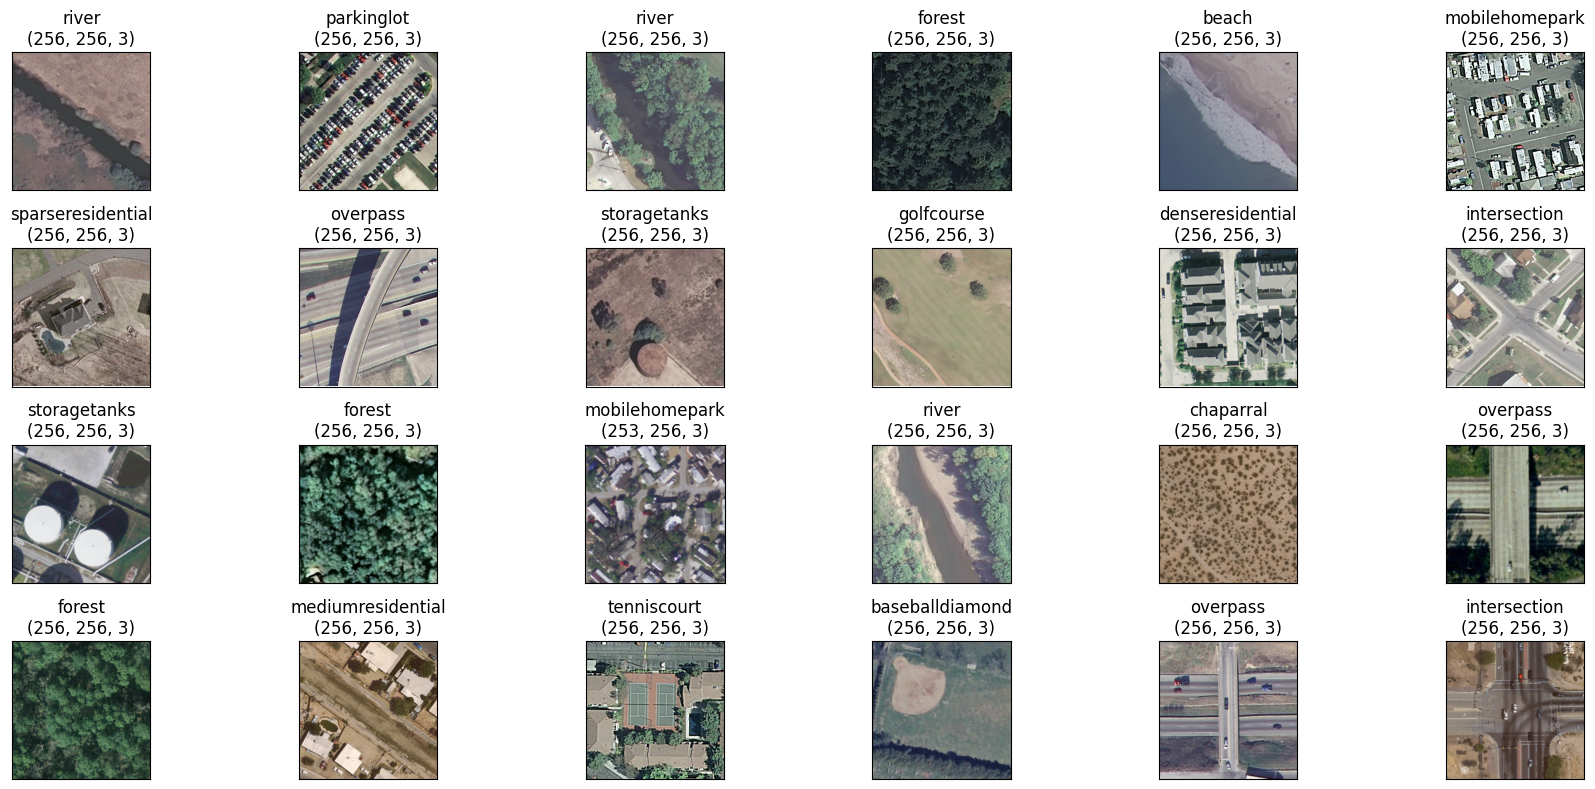

In [9]:
rows = 4
columns = 6
n = rows*columns
images = x_train[:n]
labels = y_train[:n]
fig, axes = plt.subplots(rows, columns, figsize=(3*columns,2*rows))

for i in range(n):
  img = tifffile.imread(images[i])
  img_lbl = classes[labels[i]]
  ax = axes[i//columns, i%columns]
  ax.imshow(img)
  ax.set_title('{}\n{}'.format(img_lbl, img.shape))
  ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout()
plt.show()

## **Generador de datos**

En el archivo `data_generator.py` podemos encontrar la implementación de un _custom data generator_ usando `Keras`.

Para aplicar data augmentation, vamos a usar [Albumentations](https://github.com/albumentations-team/albumentations).

In [10]:
from albumentations import Blur, \
                           Compose, \
                           HorizontalFlip, \
                           RandomBrightnessContrast, \
                           RandomRotate90, \
                           VerticalFlip

def augmentation():
    return Compose([HorizontalFlip(p=0.5),
                    VerticalFlip(p=0.5),
                    RandomRotate90(p=0.5),
                    Blur(p=0.01, blur_limit=3),
                    RandomBrightnessContrast(p=0.5),
                   ], p = 1)

In [11]:
data_gen_train = DataGenerator(path_images=x_train,
                               labels=y_train,
                               batch_size=BATCH_SIZE,
                               n_classes=n_classes,
                               target_size=TARGET_SIZE,
                               augmentation=augmentation,
                               shuffle=True)

data_gen_val = DataGenerator(path_images=x_val,
                             labels=y_val,
                             batch_size=BATCH_SIZE,
                             n_classes=n_classes,
                             target_size=TARGET_SIZE,
                             shuffle=False)

Verificar la salida del generador de datos.

Las salidas deben tener las siguientes dimensiones:

$x: [batch\_size, image\_width, image\_height, channels]$

$y: [batch\_size, number\_classes, 1]$

In [12]:
for id,(x, y) in enumerate(data_gen_train):
    print(id, x.shape, y.shape)
    break

0 (32, 256, 256, 3) (32, 21, 1)


## **Modelo de classificación de imágenes**

Vamos a usar una **VGG16** como modelo base disponible en Keras ([VGG16 and VGG19 documentation](https://keras.io/api/applications/vgg/)), pre-entrenado con el conjunto de datos [ImageNet](https://www.image-net.org/). Posteriormente,agregaremos capas densas correspondientes a nuestra aplicación.

<center>

<img width=400 src="https://miro.medium.com/max/1400/1*NNifzsJ7tD2kAfBXt3AzEg.png" img>

</center>

### **Modelos base**

#### **VGG16 completo** (con las capas de clasificación)

In [ ]:
vgg16_full = VGG16(include_top=True,
                   weights="imagenet",
                   input_shape=(224,224,3))

vgg16_full.summary()

553467096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

#### **VGG16 feature extractor** (sin las capas de clasificación)

In [ ]:
vgg16_base = VGG16(include_top=False,
                   weights="imagenet",
                   input_shape=(224,224,3))

vgg16_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

### **Función para congelar capas**

In [22]:
def freeze_up_to(model,
                 freeze_layer_name):
  """Function to freeze some layers of the model

  Args:
      model (keras.Model): a keras.Model
      freeze_layer_name (str): layer name of "model". All layers up
        to this layer will be freezed.

  Returns:
      keras.Model: a keras.Model with some layers freezed.
  """
  # Getting layer number based on layer name
  for id_layer, layer in enumerate(model.layers):

    if layer.name == freeze_layer_name:
      layer_number = id_layer
      break

  # Froze layers
  for layer in model.layers[:layer_number]:
    layer.trainable = False

  return model

### **Transfer learning**

Al usar modelo pre-entrenados, tenemos que aplicar el mismo pre-procesamiento o normalización aplicado a la hora de entrenar dicho modelo.

En este caso, `VG16` tiene una función de pre-procesamiento disponible:

```python
from tensorflow.keras.applications.vgg16 import preprocess_input
```

<center>

$trainable\_parameters = head\_parameters $

</center>

In [14]:
# Tomamos un modelo pre-entrenado como base
vgg16_1 = VGG16(include_top=False,
                weights="imagenet",
                input_shape=(TARGET_SIZE,TARGET_SIZE,3))

# Congelamos las capas del modelo base
vgg16_1.trainable = False

# Creamos un nuevo modelo agregando capas de
# clasificación al modelo base
input = Input(shape=(TARGET_SIZE,TARGET_SIZE,3))
x = preprocess_input(input)
x = vgg16_1(x)
x = Flatten()(x)
x = Dense(100, activation="relu")(x)
output = Dense(n_classes, activation="softmax")(x)

model_tl = Model(input, output)

model_tl.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                  )

model_tl.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 256, 256, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 256, 256, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                              

### **Fine tuning**

<center>

$trainable\_parameters = head\_parameters + base\_model\_parameters $

</center>

In [23]:
# Tomamos un modelo pre-entrenado como base
vgg16_2 = VGG16(include_top=False,
                weights="imagenet",
                input_shape=(TARGET_SIZE,TARGET_SIZE,3))

# Congelamos algunas capas del modelo base
vgg16_2 = freeze_up_to(vgg16_2,
                       "block5_conv2")

# Creamos un nuevo modelo agregando capas de
# clasificación al modelo base
input = Input(shape=(TARGET_SIZE,TARGET_SIZE,3))
x = preprocess_input(input)
x = vgg16_2(x)
x = Flatten()(x)
x = Dense(100, activation="relu")(x)
output = Dense(n_classes, activation="softmax")(x)

model_ft = Model(input, output)

model_ft.compile(optimizer=SGD(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                  )

model_ft.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem_3  (None, 256, 256, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               3276

## **Callbacks**

Función para guardar el modelo

In [16]:
def get_ckpt(ckpt_name):
    return ModelCheckpoint(ckpt_name,
                           mode="max",
                           save_best_only=True,
                           monitor="val_accuracy",
                           verbose=1)

In [24]:
# Callbacks
# Checkpoints
autosave_tl = get_ckpt("classification_vgg16_transfer_learning.h5")
autosave_ft = get_ckpt("classification_vgg16_fine_tuning.h5")

# Early stopping
early_stopping = EarlyStopping(patience=30,
                               verbose=1,
                               monitor="val_accuracy",
                               mode='max')

cbks_tl = [autosave_tl, early_stopping]
cbks_ft = [autosave_ft, early_stopping]

## **Entrenamiento**

### **Transfer learning**

In [18]:
history_tl = model_tl.fit(data_gen_train,
                          epochs=EPOCHS,
                          validation_data=data_gen_val,
                          callbacks=cbks_tl,
                          workers=4,
                          use_multiprocessing=True
                          )

Epoch 1/200
40/40 [==============================] - ETA: 0s - loss: 4.4625 - accuracy: 0.5032
Epoch 1: val_accuracy improved from -inf to 0.65952, saving model to classification_vgg16_transfer_learning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 84s 2s/step - loss: 4.4625 - accuracy: 0.5032 - val_loss: 1.5673 - val_accuracy: 0.6595
Epoch 2/200
40/40 [==============================] - ETA: 0s - loss: 1.0913 - accuracy: 0.7230
Epoch 2: val_accuracy improved from 0.65952 to 0.71429, saving model to classification_vgg16_transfer_learning.h5
40/40 [==============================] - 12s 274ms/step - loss: 1.0913 - accuracy: 0.7230 - val_loss: 1.2864 - val_accuracy: 0.7143
Epoch 3/200
40/40 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.7937
Epoch 3: val_accuracy improved from 0.71429 to 0.78095, saving model to classification_vgg16_transfer_learning.h5
40/40 [==============================] - 11s 263ms/step - loss: 0.8152 - accuracy: 0.7937 - val_loss: 0.9829 - val_accuracy: 0.7810
Epoch 4/200
40/40 [==============================] - ETA: 0s - loss: 0.7076 - accuracy: 0.8325
Epoch 4: val_accuracy improved from 0.78095 to 0.81429, saving model to classification_vgg16_t

### **Fine tuning**

In [25]:
history_ft = model_ft.fit(data_gen_train,
                          epochs=EPOCHS,
                          validation_data=data_gen_val,
                          callbacks=cbks_ft,
                          workers=4,
                          use_multiprocessing=True
                          )

Epoch 1/200
40/40 [==============================] - ETA: 0s - loss: 3.3048 - accuracy: 0.3944
Epoch 1: val_accuracy improved from -inf to 0.63333, saving model to classification_vgg16_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 20s 455ms/step - loss: 3.3048 - accuracy: 0.3944 - val_loss: 1.3813 - val_accuracy: 0.6333
Epoch 2/200
40/40 [==============================] - ETA: 0s - loss: 1.0221 - accuracy: 0.7151
Epoch 2: val_accuracy improved from 0.63333 to 0.72857, saving model to classification_vgg16_fine_tuning.h5
40/40 [==============================] - 13s 292ms/step - loss: 1.0221 - accuracy: 0.7151 - val_loss: 1.0592 - val_accuracy: 0.7286
Epoch 3/200
40/40 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.8341
Epoch 3: val_accuracy improved from 0.72857 to 0.78571, saving model to classification_vgg16_fine_tuning.h5
40/40 [==============================] - 18s 437ms/step - loss: 0.6245 - accuracy: 0.8341 - val_loss: 0.8387 - val_accuracy: 0.7857
Epoch 4/200
40/40 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8873
Epoch 4: val_accuracy improved from 0.78571 to 0.80000, saving model to classification_vgg16_fine_tunin

**Evolución de los modelos durante entrenamiento**

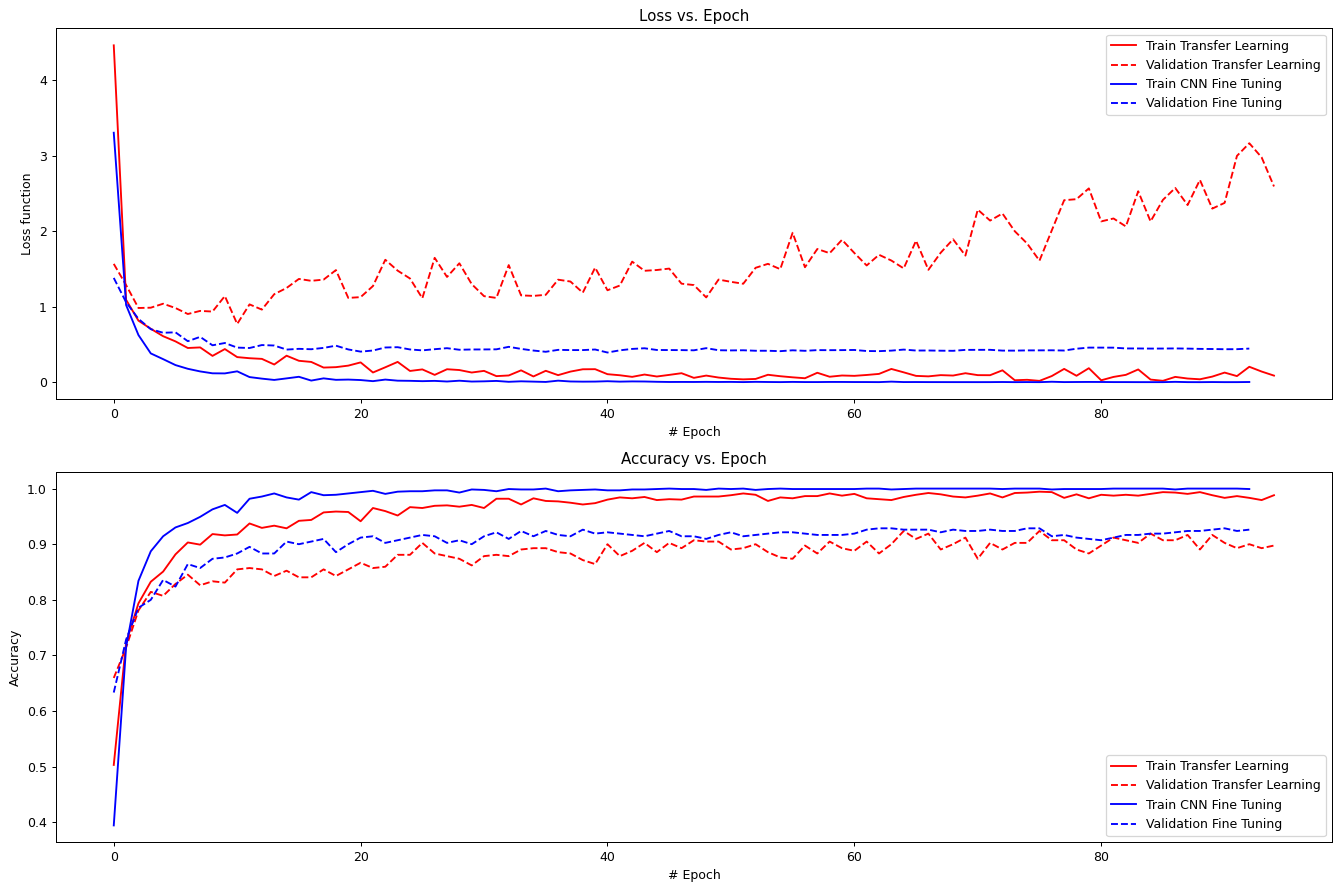

In [26]:
fig_labels = ["Train Transfer Learning",
              "Validation Transfer Learning",
              "Train CNN Fine Tuning",
              "Validation Fine Tuning"]

plt.figure(figsize=(15,10), dpi=90)

plt.subplot(2,1,1)
plt.plot(history_tl.history["loss"], "r-")
plt.plot(history_tl.history["val_loss"], "r--")
plt.plot(history_ft.history["loss"], "b-")
plt.plot(history_ft.history["val_loss"], "b--")
plt.xlabel("# Epoch")
plt.ylabel("Loss function")
plt.legend(fig_labels)
plt.title("Loss vs. Epoch")

plt.subplot(2,1,2)
plt.plot(history_tl.history["accuracy"], "r-")
plt.plot(history_tl.history["val_accuracy"], "r--")
plt.plot(history_ft.history["accuracy"], "b-")
plt.plot(history_ft.history["val_accuracy"], "b--")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(fig_labels)
plt.title("Accuracy vs. Epoch")

plt.tight_layout()

plt.show()

**Cargando los modelos entrenados**

In [27]:
model_tl.load_weights("classification_vgg16_transfer_learning.h5")
model_ft.load_weights("classification_vgg16_fine_tuning.h5")

## **Evaluando los modelos**

Creando un generador de datos para el conjunto de pruebas

In [28]:
data_gen_test = DataGenerator(path_images=x_test,
                              labels=y_test,
                              batch_size=BATCH_SIZE,
                              n_classes=n_classes,
                              target_size=TARGET_SIZE,
                              shuffle=False)

In [29]:
print("Entrenamiento:")
scores_train_1 = model_tl.evaluate(data_gen_train)
scores_train_2 = model_ft.evaluate(data_gen_train)

print("Validación:")
scores_val_1 = model_tl.evaluate(data_gen_val)
scores_val_2 = model_ft.evaluate(data_gen_val)

print("Pruebas:")
scores_test_1 = model_tl.evaluate(data_gen_test)
scores_test_2 = model_ft.evaluate(data_gen_test)

Train:
40/40 [==============================] - 7s 179ms/step - loss: 8.7571e-04 - accuracy: 1.0000
Validation:
14/14 [==============================] - 3s 179ms/step - loss: 0.4113 - accuracy: 0.9286
Test:
14/14 [==============================] - 3s 171ms/step - loss: 0.6101 - accuracy: 0.9071


<center>

|Loss &darr; |Entrenamiento |Validación|- |Accuracy &uarr;|Entrenamiento |Validación|
|-----|------|----------|--|--------|------|----------|
|VGG16 transfer learning|0.0587|1.508|- |        |98.89| 92.4   |
|VGG16 fine tuning|**0.000875**|**0.411**|- |        |**100**| **92.8**  |

</center>

<br/>

<details>
  <summary>Resultados en el conjunto de pruebas</summary>
  
  <center>

  |Loss &darr; |Test |- |Accuracy &uarr;|Pruebas|
  |-----|-----|- |--------|----|
  |VGG16 transfer learning|1.712 |- |        |**92.1**|
  |VGG16 fine tuning|**0.610** |- |        |90.7|

  </center>

</details>